## Strain data analysis

In [193]:
import numpy as np
import helper
import mutualinfo
import pandas as pd
from scipy import stats
from scipy.stats import norm
# import statsmodels.api as sm
# from sklearn import metrics
import matplotlib.pyplot as plt
# from sklearn.feature_selection import mutual_info_regression
# from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.dpi'] = 200
import seaborn as sns

In [194]:
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.geometry.hypersphere import Hypersphere
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

np.random.seed(1)
gs.random.seed(1000)

In [195]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

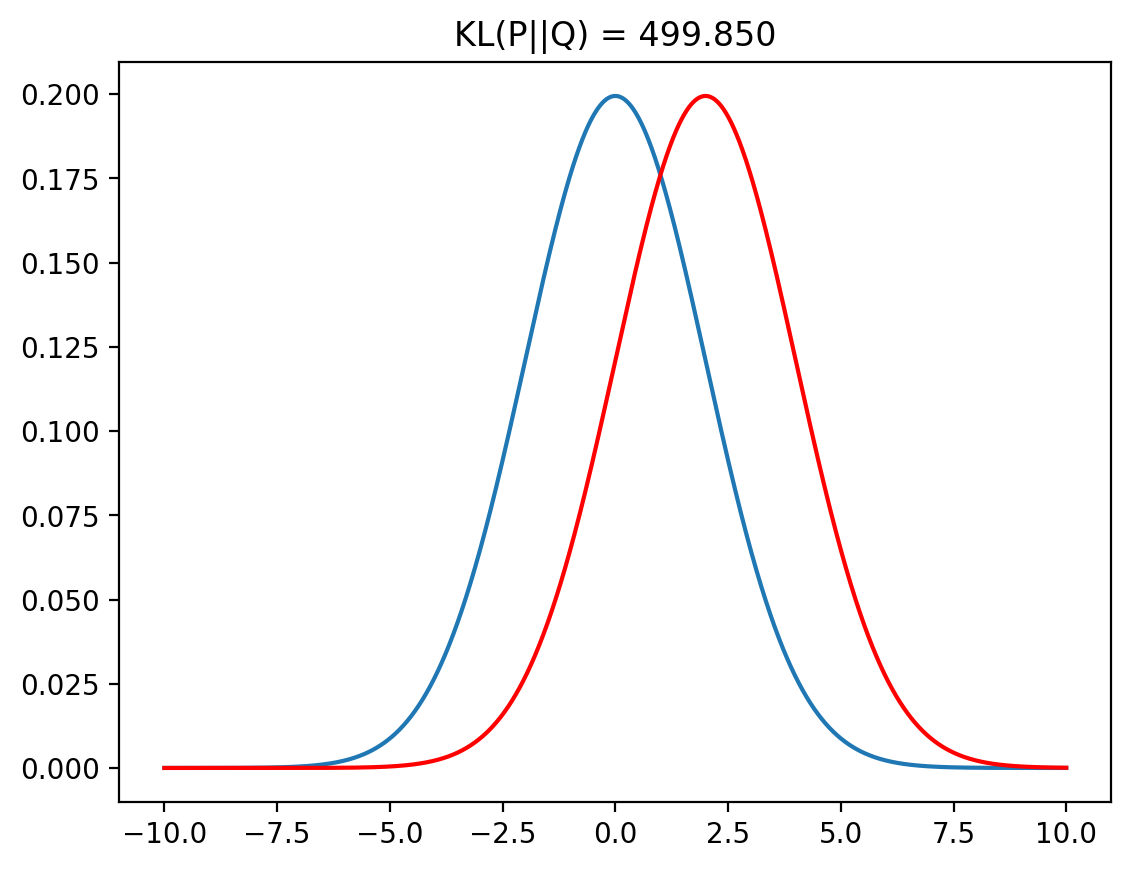

In [196]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 2, 2)
plt.title('KL(P||Q) = %1.3f' % kl_divergence(q, p))
plt.plot(x, p)
plt.plot(x, q, c='red')

In [197]:
def pyriemann_clusters(data):
    
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    
    kmeans = Kmeans(3, metric='riemann', tol=1e-3, init='random')
    kmeans.fit(data)
    labels = kmeans.predict(data)
    centroids = kmeans.centroids
    print(labels)
    
#     for k in K:
#         kmeans = KMeans(k, 'riemann', tol=1e-3, init='random')
#         kmeans.fit(data)
#         labels = kmeans.predict(data)
#         centroids = kmeans.centroids
#         print(labels)
        
#         distortions.append(sum(np.min(cdist(data, kmeans.centroids, 'euclidean'), axis=1)) / np.array(data).shape[0])
#         inertias.append(kmeans.inertia_)
#         mapping1[k] = sum(np.min(cdist(data, kmeans.centroids, 'euclidean'), axis=1)) / np.array(data).shape[0]
#         mapping2[k] = kmeans.inertia_
        
#     #   The elbow method for optimal number of clusters
#     plt.plot(K, inertias, 'bx-')
#     plt.xlabel('Values of K')
#     plt.ylabel('Distortion')
#     plt.title('The Elbow Method using Distortion')
#     plt.show()
    
    return labels

In [198]:
def cluster(data):
    
#     sphere = Hypersphere(dim=2)
#     cluster = sphere.random_von_mises_fisher(kappa=20, n_samples=140)

#     SO3 = SpecialOrthogonal(3)
#     rotation1 = SO3.random_uniform()
#     rotation2 = SO3.random_uniform()

#     cluster_1 = cluster @ rotation1
#     cluster_2 = cluster @ rotation2

#     fig = plt.figure(figsize=(15, 15))
#     ax = visualization.plot(
#     cluster_1, space="S2", color="red", alpha=0.7, label="Data points 1 "
#     )
#     ax = visualization.plot(
#     cluster_2, space="S2", ax=ax, color="blue", alpha=0.7, label="Data points 2"
#     )
#     ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
#     ax.legend();
    
    
    manifold = Hypersphere(dim=3) #3
    metric = manifold.metric

#     cluster_1 = np.array([[2, 3, 4], [2, 2, 4], [4, 22, 11], [4, 22, 11], [14, 22, 1], [2, 12, 4] , [40, 22, 101], [2, 2, 4] , [4, 22, 22]])
#     cluster_2 = np.array([[27, -33, 4], [72, -2, 4], [4, 220, 11], [-74, 22, 1], [14, 32, 18], [-12, 2, 4] , [-49, 27, 10], [-2, 82, 4] , [14, 22, 2]])
#     data = gs.concatenate((cluster_1, cluster_2), axis=0)

#     kmeans = RiemannianKMeans(metric, 2, tol=1e-3, init_step_size=1.0)
#     kmeans.fit(data)
#     labels = kmeans.predict(data)
#     centroids = kmeans.centroids
#     print(labels)
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = (2, 6)
    
    for k in K:
        kmeans = RiemannianKMeans(metric, k, tol=1e-3, init_step_size=1.0)
        kmeans.fit(data)
        labels = kmeans.predict(data)
        centroids = kmeans.centroids
        print(labels)
        
        distortions.append(sum(np.min(cdist(data, kmeans.centroids, 'euclidean'), axis=1)) / np.array(data).shape[0])
        inertias.append(kmeans.inertia_)
        mapping1[k] = sum(np.min(cdist(data, kmeans.centroids, 'euclidean'), axis=1)) / np.array(data).shape[0]
        mapping2[k] = kmeans.inertia_
        
    #   The elbow method for optimal number of clusters
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()
    
    return labels

In [199]:
from sklearn.cluster import KMeans
from pyriemann.clustering import Kmeans
from sklearn import metrics
from scipy.spatial.distance import cdist

def cov_cluster(data, wsize, dist_metric):
    
    winsize = wsize
    start = 0
    covmat = []
    covar = []
    columns = data.columns
    dim = len(columns) - 1
    cluster_idx = []
 
    while start+winsize < len(data)-1:
        cluster_idx.append(start)
#         print(f"Data shape: {data.shape}")
        data_batch = data[start: start + winsize]
#         print(f"Data batch: {data_batch.shape}")
        ls_data_batch = []
        
        for i in range(len(columns)):
            ls_data_batch.append(data_batch[columns[i]].values.tolist())

        cov = np.cov(np.array(ls_data_batch))
#         print(f"Covariance of {columns[14]} with other variables: {cov[14]}")
#         flat_cov = np.concatenate(cov).ravel().tolist()
        upper = np.triu(cov, k=0)
#         print(f"Length of Cov matrix: {len(upper[upper!=0])}")
        mask = np.triu_indices(dim)
        newupp = list(upper[mask])
        upp = list(upper[upper!=0])
        
#         mean_v = list(np.mean(np.array(ls_data_batch), axis=1))
        
        feat = stats.describe(np.array(ls_data_batch), axis=1)
        mean_val = feat.mean.tolist()
        skewness = feat.skewness.tolist()
        kurtosis = feat.kurtosis.tolist()
        
#         plt.plot(helper.normalize(newupp, 'std'))
#         plt.show()
        mix_feat = newupp 
#         print(f"Length of features pool: {len(mix_feat)}")
        covmat.append(mix_feat)
        covar.append(cov)
#         print(covmat)
        start = start + winsize
    
        distortions = []
        inertias = []
        mapping1 = {}
        mapping2 = {}
        K = (2, 6)
    
    
    
    if dist_metric == 'Euclidean':
        
        kmeans = KMeans(n_clusters=3, random_state=0, n_init=1).fit(covmat)
        clusters = list(kmeans.labels_)
        print(f"Clusters: {list(kmeans.labels_)}")
    
#     for k in K:
#             kmeans = KMeans(n_clusters=k, random_state=0, n_init=1).fit(covmat)
#             clusters = list(kmeans.labels_)
#             print(f"Clusters: {list(kmeans.labels_)}")
        
#             distortions.append(sum(np.min(cdist(covmat, kmeans.cluster_centers_, 'mahalanobis'), axis=1)) / np.array(covmat).shape[0])
#             inertias.append(kmeans.inertia_)
#             mapping1[k] = sum(np.min(cdist(covmat, kmeans.cluster_centers_, 'mahalanobis'), axis=1)) / np.array(covmat).shape[0]
#             mapping2[k] = kmeans.inertia_
        
#         #   The elbow method for optimal number of clusters
#         plt.plot(K, inertias, 'bx-')
#         plt.xlabel('Values of K')
#         plt.ylabel('Distortion')
#         plt.title('The Elbow Method using Distortion')
#         plt.show()
    
    else:
#         clusters = cluster(np.array(covmat))
        clusters = pyriemann_clusters(np.array(covar))
#     
#     print(f"Clusters indecis: {cluster_idx}")
    return clusters, cluster_idx

In [200]:
def ClaSP(time_series, tcps):
    
    plt.plot(time_series)
    plt.show()
    clasp = BinaryClaSPSegmentation()
    regimes = clasp.fit_predict(time_series)
    clasp.plot(gt_cps=tcps, heading="Segmentation", ts_name="ACC", file_path="segmentation_example.png")
    
    return regimes

Yoga
[7295]


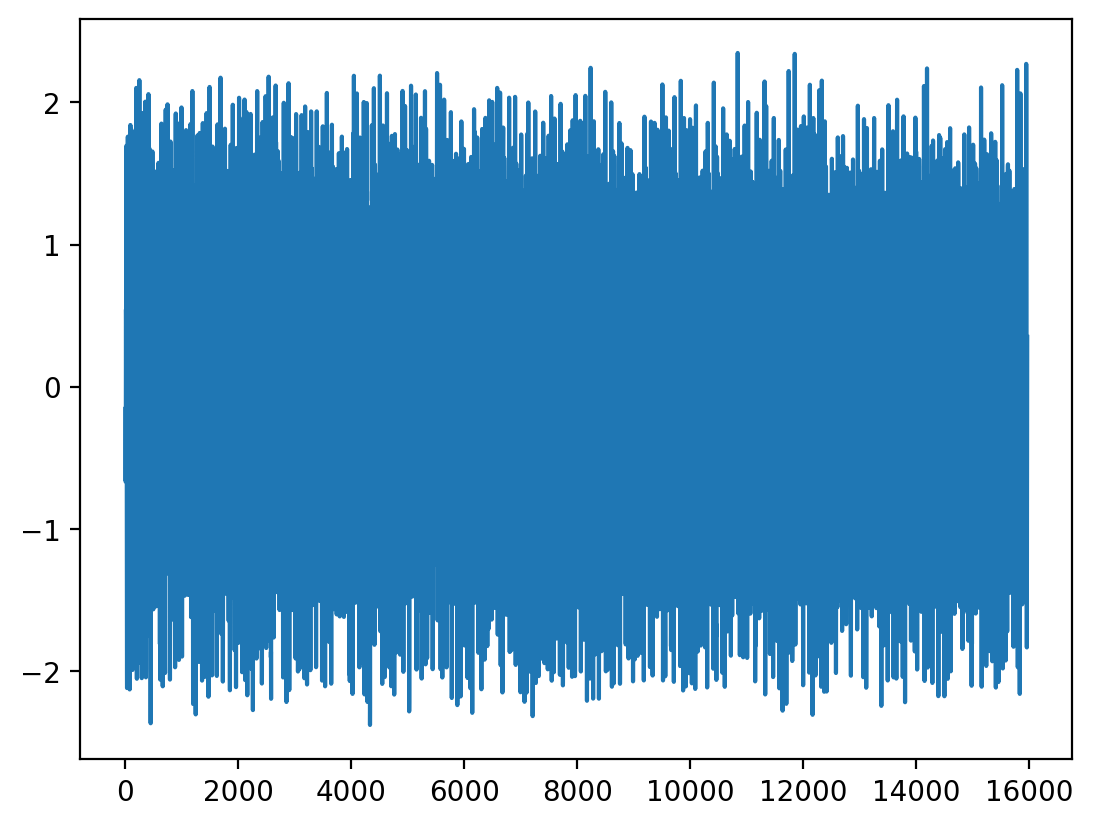

[ 7191 12175]


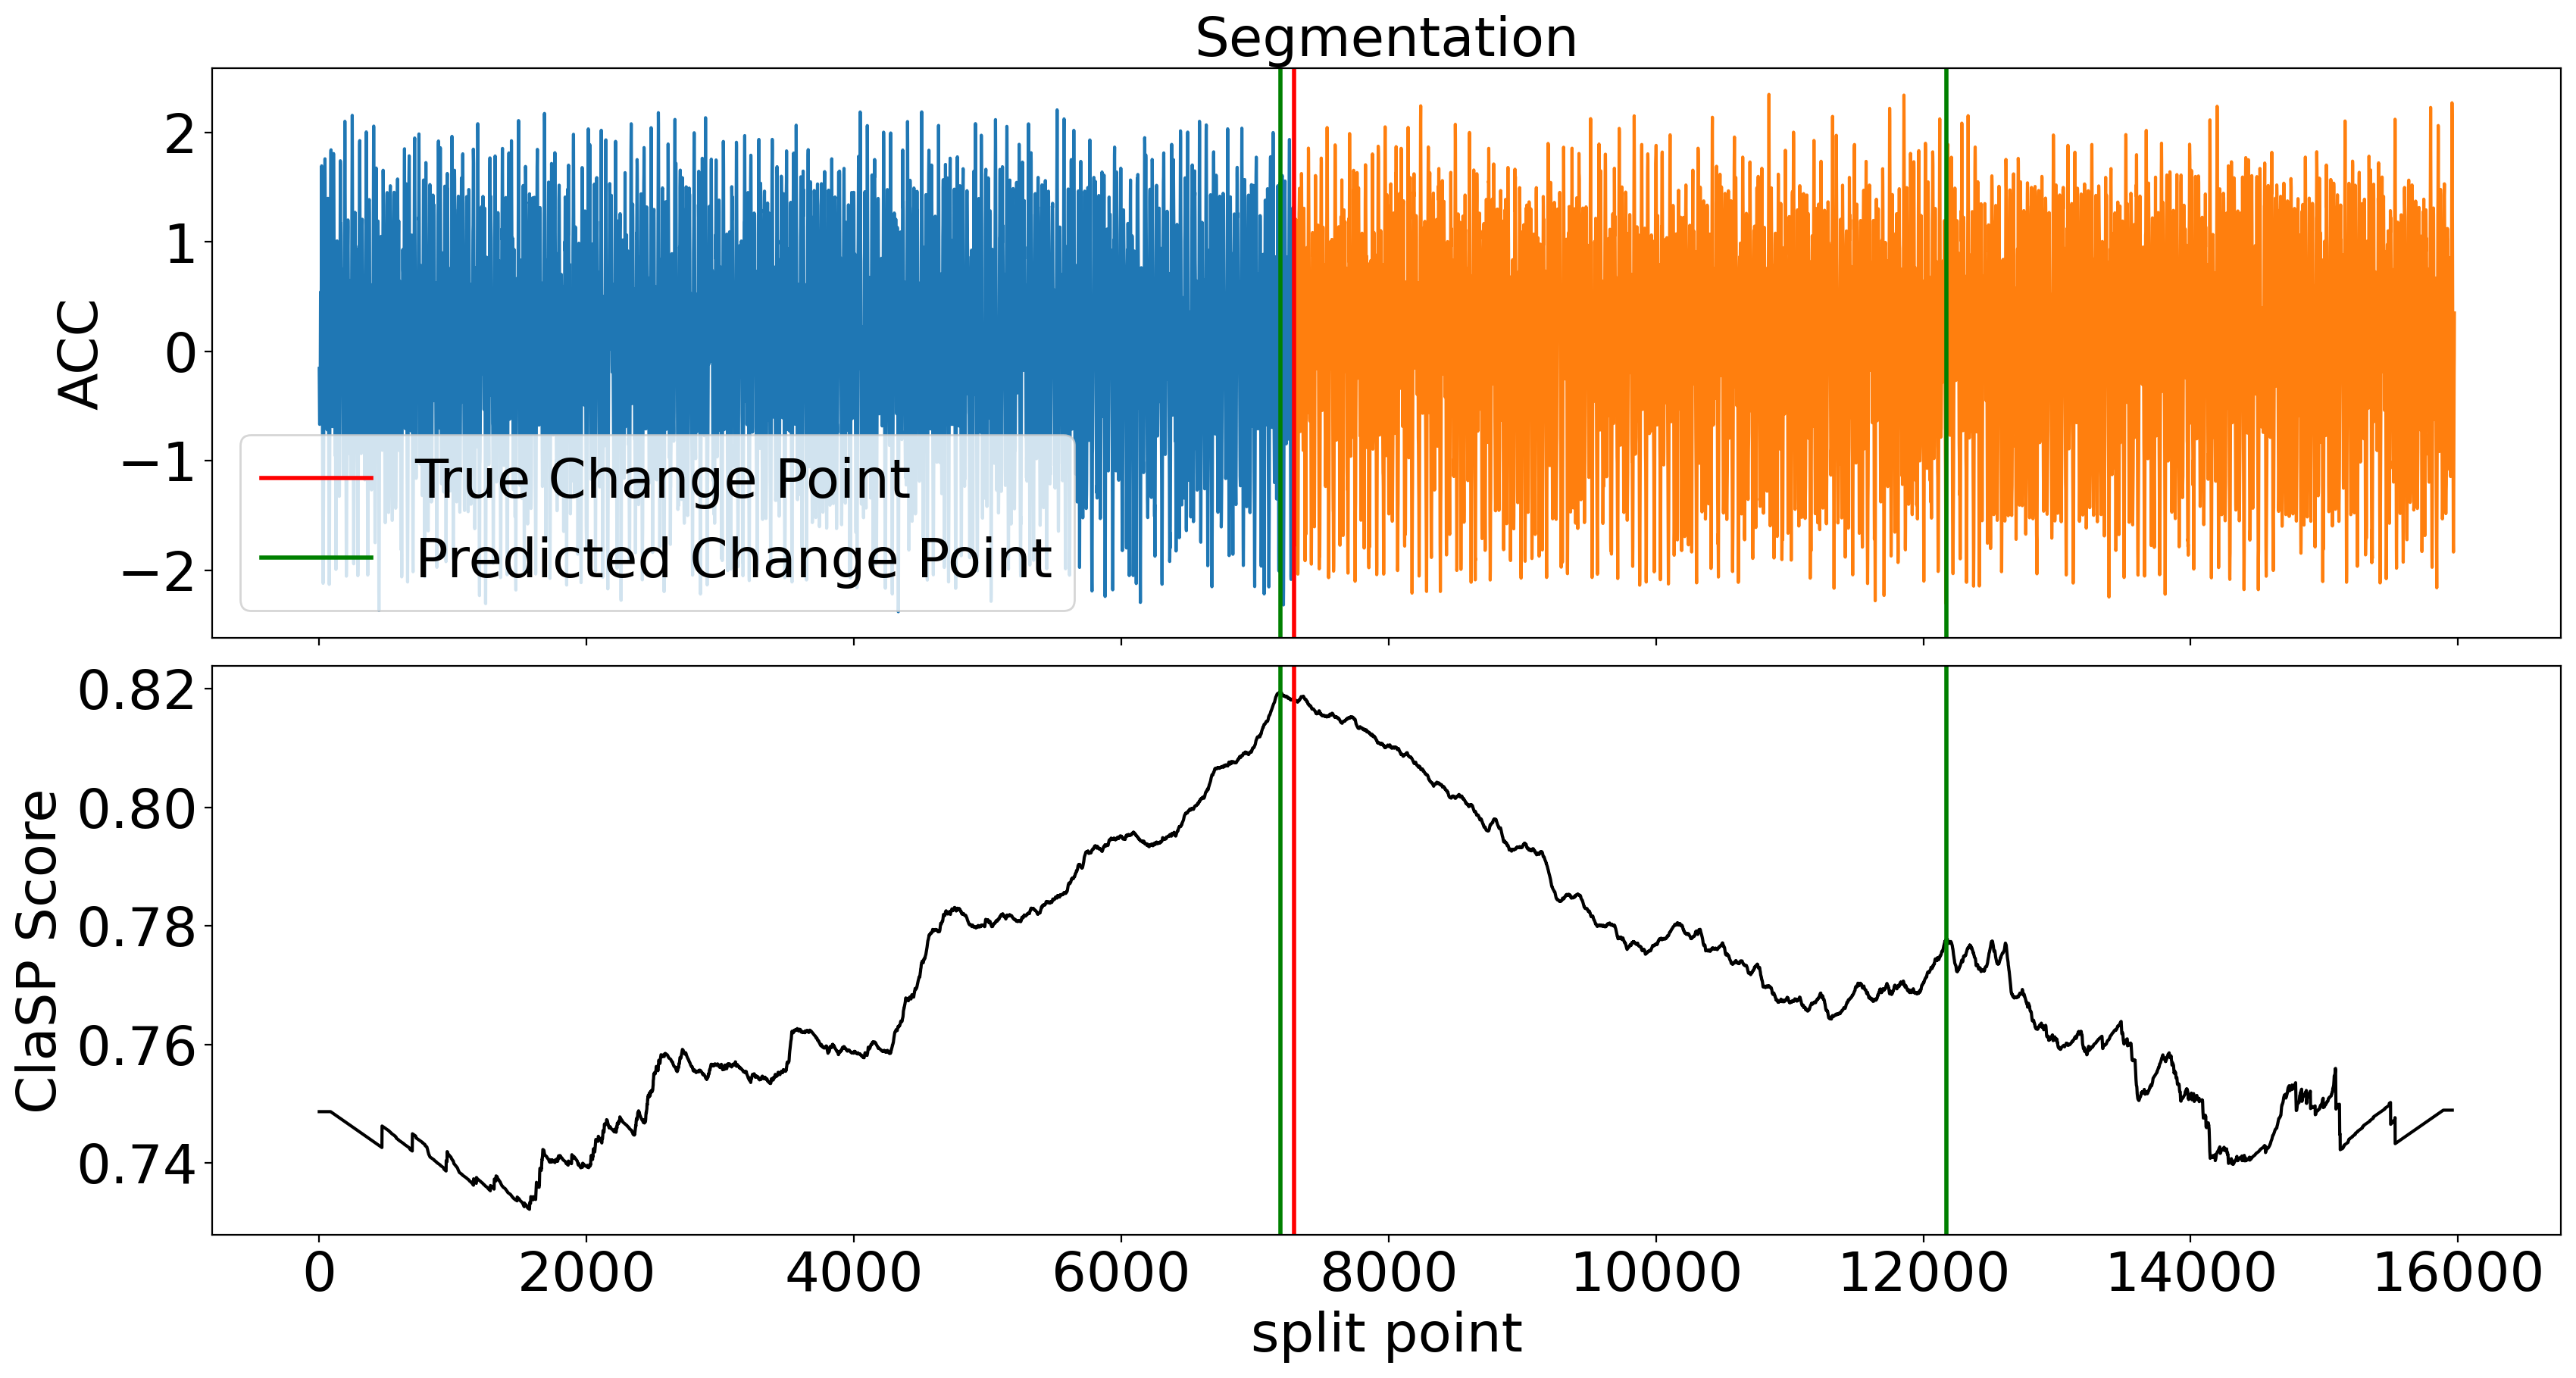

In [201]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset

dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("Yoga", )).iloc[0, :]
print(dataset)
print(true_cps)
clusters = ClaSP(time_series, true_cps)
print(clusters)

In [202]:
x = np.transpose([[11, 32, 35, 49, 15, 56, 37, 28, 19, 30]])
x1 = [1, 2, 35, 9, 15, 56, 7, 28, 19, 30]
y = [11, 32, 35, 9, 15, 56, 3, 8, 1, 30]
z = [11, 32, 35, 9, 1115, 56, 3, 8, 1, 3]
# mi = mutual_info_regression(x, y)
# print(mi)
# print(metrics.mutual_info_score(x1, y))
cov = np.cov(np.array([x1, y, z]))
mask = np.triu_indices(3)
print(cov)
print(np.concatenate(cov).ravel().tolist())
upper = np.triu(cov, k=0)
print(upper[mask])
print(upper[upper!=0])

[[   298.4           207.33333333   -457.62222222]
 [   207.33333333    309.55555556   -331.55555556]
 [  -457.62222222   -331.55555556 120760.23333333]]
[298.4, 207.33333333333331, -457.62222222222215, 207.33333333333331, 309.55555555555554, -331.5555555555555, -457.62222222222215, -331.5555555555555, 120760.23333333334]
[   298.4           207.33333333   -457.62222222    309.55555556
   -331.55555556 120760.23333333]
[   298.4           207.33333333   -457.62222222    309.55555556
   -331.55555556 120760.23333333]


In [203]:
def adf_test(ts):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [204]:
def plot_heatmap(df, cause): # Increase the size of the heatmap.
    plt.figure(figsize=(16, 8))
    # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
    # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
    heatmap = sns.heatmap(df, vmin=0, vmax=np.max(cause), annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Causal Impact Heatmap', fontdict={'fontsize':15}, pad=12);
    plt.savefig("causal_heatmap15May-Aug_subset_nsc.eps", format='eps')

In [205]:
# data = pd.read_csv(r'data/moxa_data_D.csv')
data = pd.read_csv(r'data/synthetic_datac.csv')

In [206]:
# start, end = '2016-06-15', '2016-12-30'
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]
# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Z1      1100 non-null   float64
 1   Z2      1100 non-null   float64
 2   Z3      1100 non-null   float64
 3   Z4      1100 non-null   float64
 4   Z5      1100 non-null   float64
dtypes: float64(5)
memory usage: 51.6 KB


In [207]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

In [208]:
data.isna().sum().sum()

0

In [209]:
data = data.apply(helper.normalize)
data.head(100)

,Z1,Z2,Z3,Z4,Z5
0,0.392774,0.384298,0.228360,0.386939,0.502451
1,0.516602,0.511224,0.436225,0.583319,0.502090
2,0.536742,0.531345,0.520703,0.516810,0.406364
3,0.621037,0.605209,0.507146,0.618633,0.477838
4,0.491270,0.484192,0.060076,0.472417,0.515868
...,...,...,...,...,...
95,0.497890,0.488537,0.476392,0.419923,0.527912
96,0.391257,0.374165,0.444695,0.379999,0.513682
97,0.427033,0.419451,0.565895,0.445341,0.431990
98,0.461512,0.462201,0.469378,0.426005,0.405188


In [210]:
data.isnull().sum()

Z1    0
Z2    0
Z3    0
Z4    0
Z5    0
dtype: int64

In [211]:
# data.isna().sum().sum()

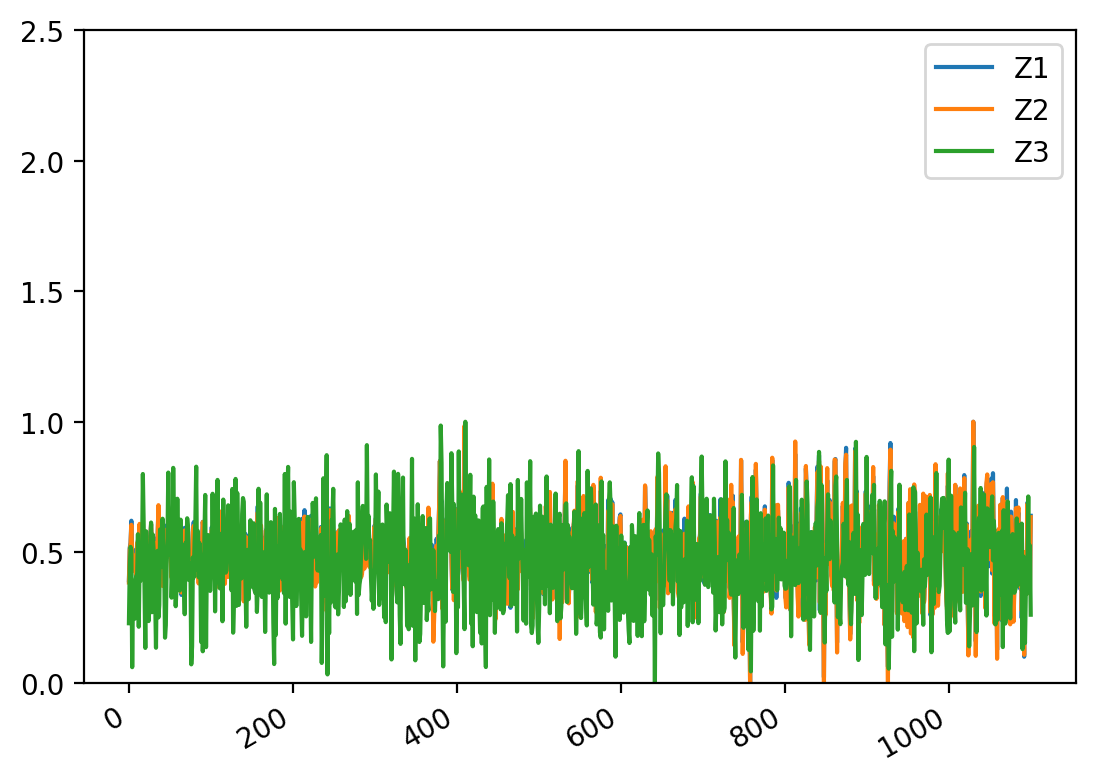

In [212]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'gw_west', 'gw_south', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z3']

for i in toplot:
    data[i].plot(use_index=True)
    plt.legend(toplot)


plt.ylim(0, 2.50)
plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
plt.legend(['Z1', 'Z2','Z3'])
plt.savefig("synreg25Apr.png")
plt.show()

In [213]:
ts = np.stack((time_series, np.random.normal(0, 1, len(time_series))), axis=1)
ts = pd.DataFrame(ts, columns=['t1', 't2'])
ts.shape
# time_series.shape

(15974, 2)

In [227]:
winsize = 60 # 85
metricE = 'Euclidean'
metricR = 'Riemannian'
clusters, cluster_idx = cov_cluster(data, winsize, metricR)

[1 1 1 1 1 1 2 2 2 2 2 2 0 3 3 3 0 3]


In [215]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
print(len(clusters_extended), data.shape)

1040 (1100, 5)


In [216]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

In [217]:
# dfs = []
# for c in range(len(list(set(clusters)))):
#         dfs.append(datanew.loc[datanew['Clusters'] == list(set(clusters))[c]])

In [218]:
# dfs[2].head()

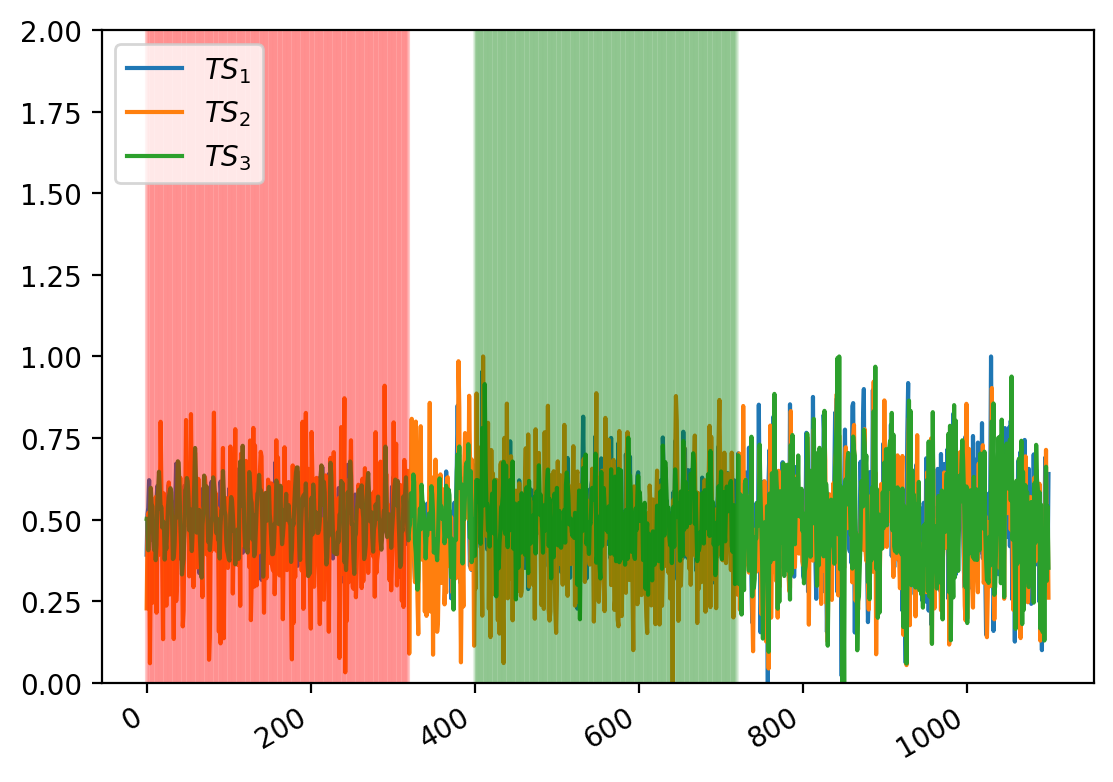

In [219]:
# toplot = [ 'rain','strain_ns_corrected', 'tides_ns', 'temperature_outside', 'pressure_outside', 'gw_west']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'gw_west', 'gw_south', 'strain_ns_corrected']
toplot = ['Z1', 'Z3', 'Z5']
# toplot = ['Hs', 'P', 'W' ]
colors = ['r', 'g', 'b', 'y', 'c']
# toplot = ['t1', 't2']

t = np.arange(0, cluster_idx[-1]+winsize)
start = 0


# for c in range(len(clusters)):
    
#     if clusters[c] == 0:
#             marker = '-'
#     elif clusters[c] == 1:
#             marker = '-'
#     elif clusters[c] == 2:
#             marker = '-'
#     for i in toplot:
        
#         data[i].plot(use_index=True)
#         plt.legend(toplot)
# #         plt.plot(t[start: start+winsize], data[toplot[i]].values[start: start + winsize], colors[i]+marker)
# #         plt.plot(t[start: start + winsize], data[toplot[i+1]].values[start: start + winsize], color)
# #         plt.plot(t[start: start + winsize], data[toplot[i+2]].values[start: start + winsize], color)
        
#     start = start + winsize




for i in toplot:
        data[i].plot(use_index=True)
        plt.legend(toplot)
#         plt.plot(t[start: start+winsize], data[toplot[i]].values[start: start + winsize], colors[i]+marker)
#         plt.plot(t[start: start + winsize], data[toplot[i+1]].values[start: start + winsize], color)
#         plt.plot(t[start: start + winsize], data[toplot[i+2]].values[start: start + winsize], color)

# plt.legend(toplot)
for c in range(len(cluster_idx)):
    val = cluster_idx[c]
    if clusters[c] == 0:
        for v in range(winsize):
            plt.axvline(val+v, color="green", alpha=0.1)
    if clusters[c] == 1:
        for v in range(winsize):
            plt.axvline(val+v, color="white", alpha=0.00)
    if clusters[c] == 2:
        for v in range(winsize):
            plt.axvline(val+v, color="red", alpha=0.1)
# plt.axvline(x=365, color='black')
# plt.axvline(x=730, color='black')
plt.ylim(0, 2.0)
plt.gcf().autofmt_xdate()
plt.legend(['$TS_{1}$', '$TS_{2}$', '$TS_{3}$'], loc='upper left')
# plt.legend(['GW$_{mb}$', 'GW$_{sg}$', 'T$_{out}$', 'Strain$_{ew}$', 'Strain$_{ns}$'], loc='upper right')
# plt.savefig("georegimes.pdf")
plt.show()

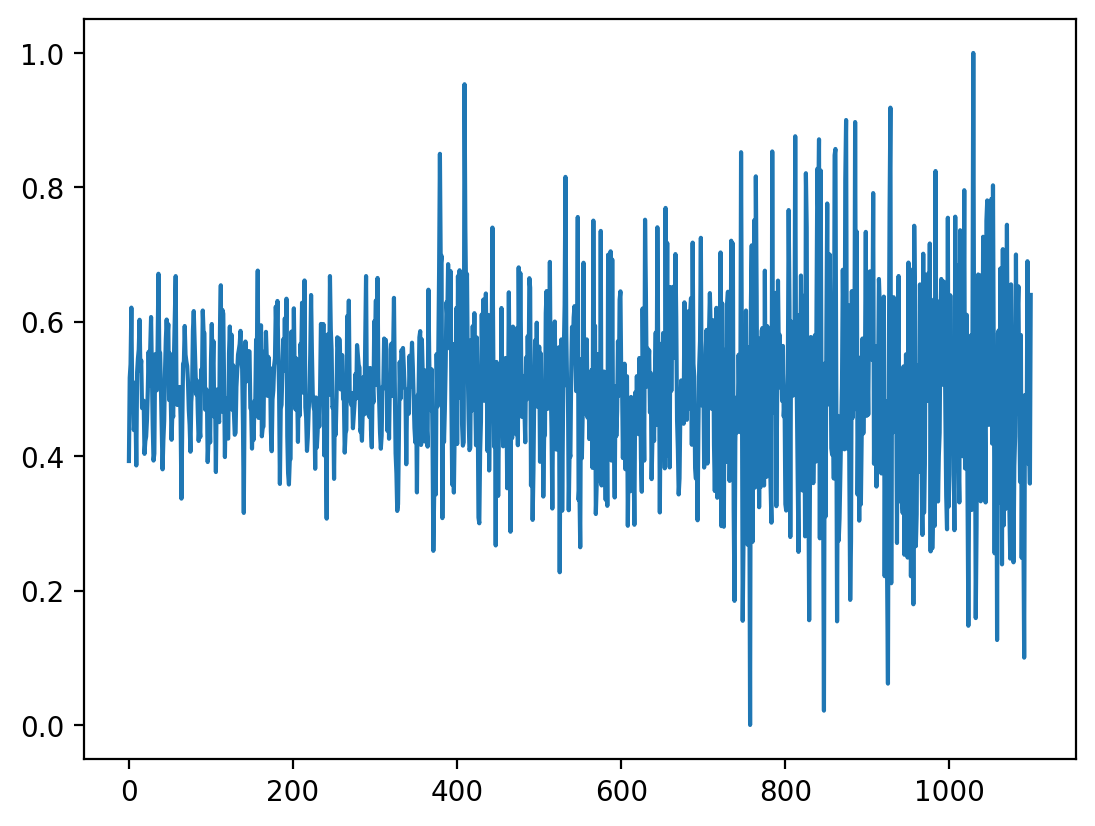

[454]


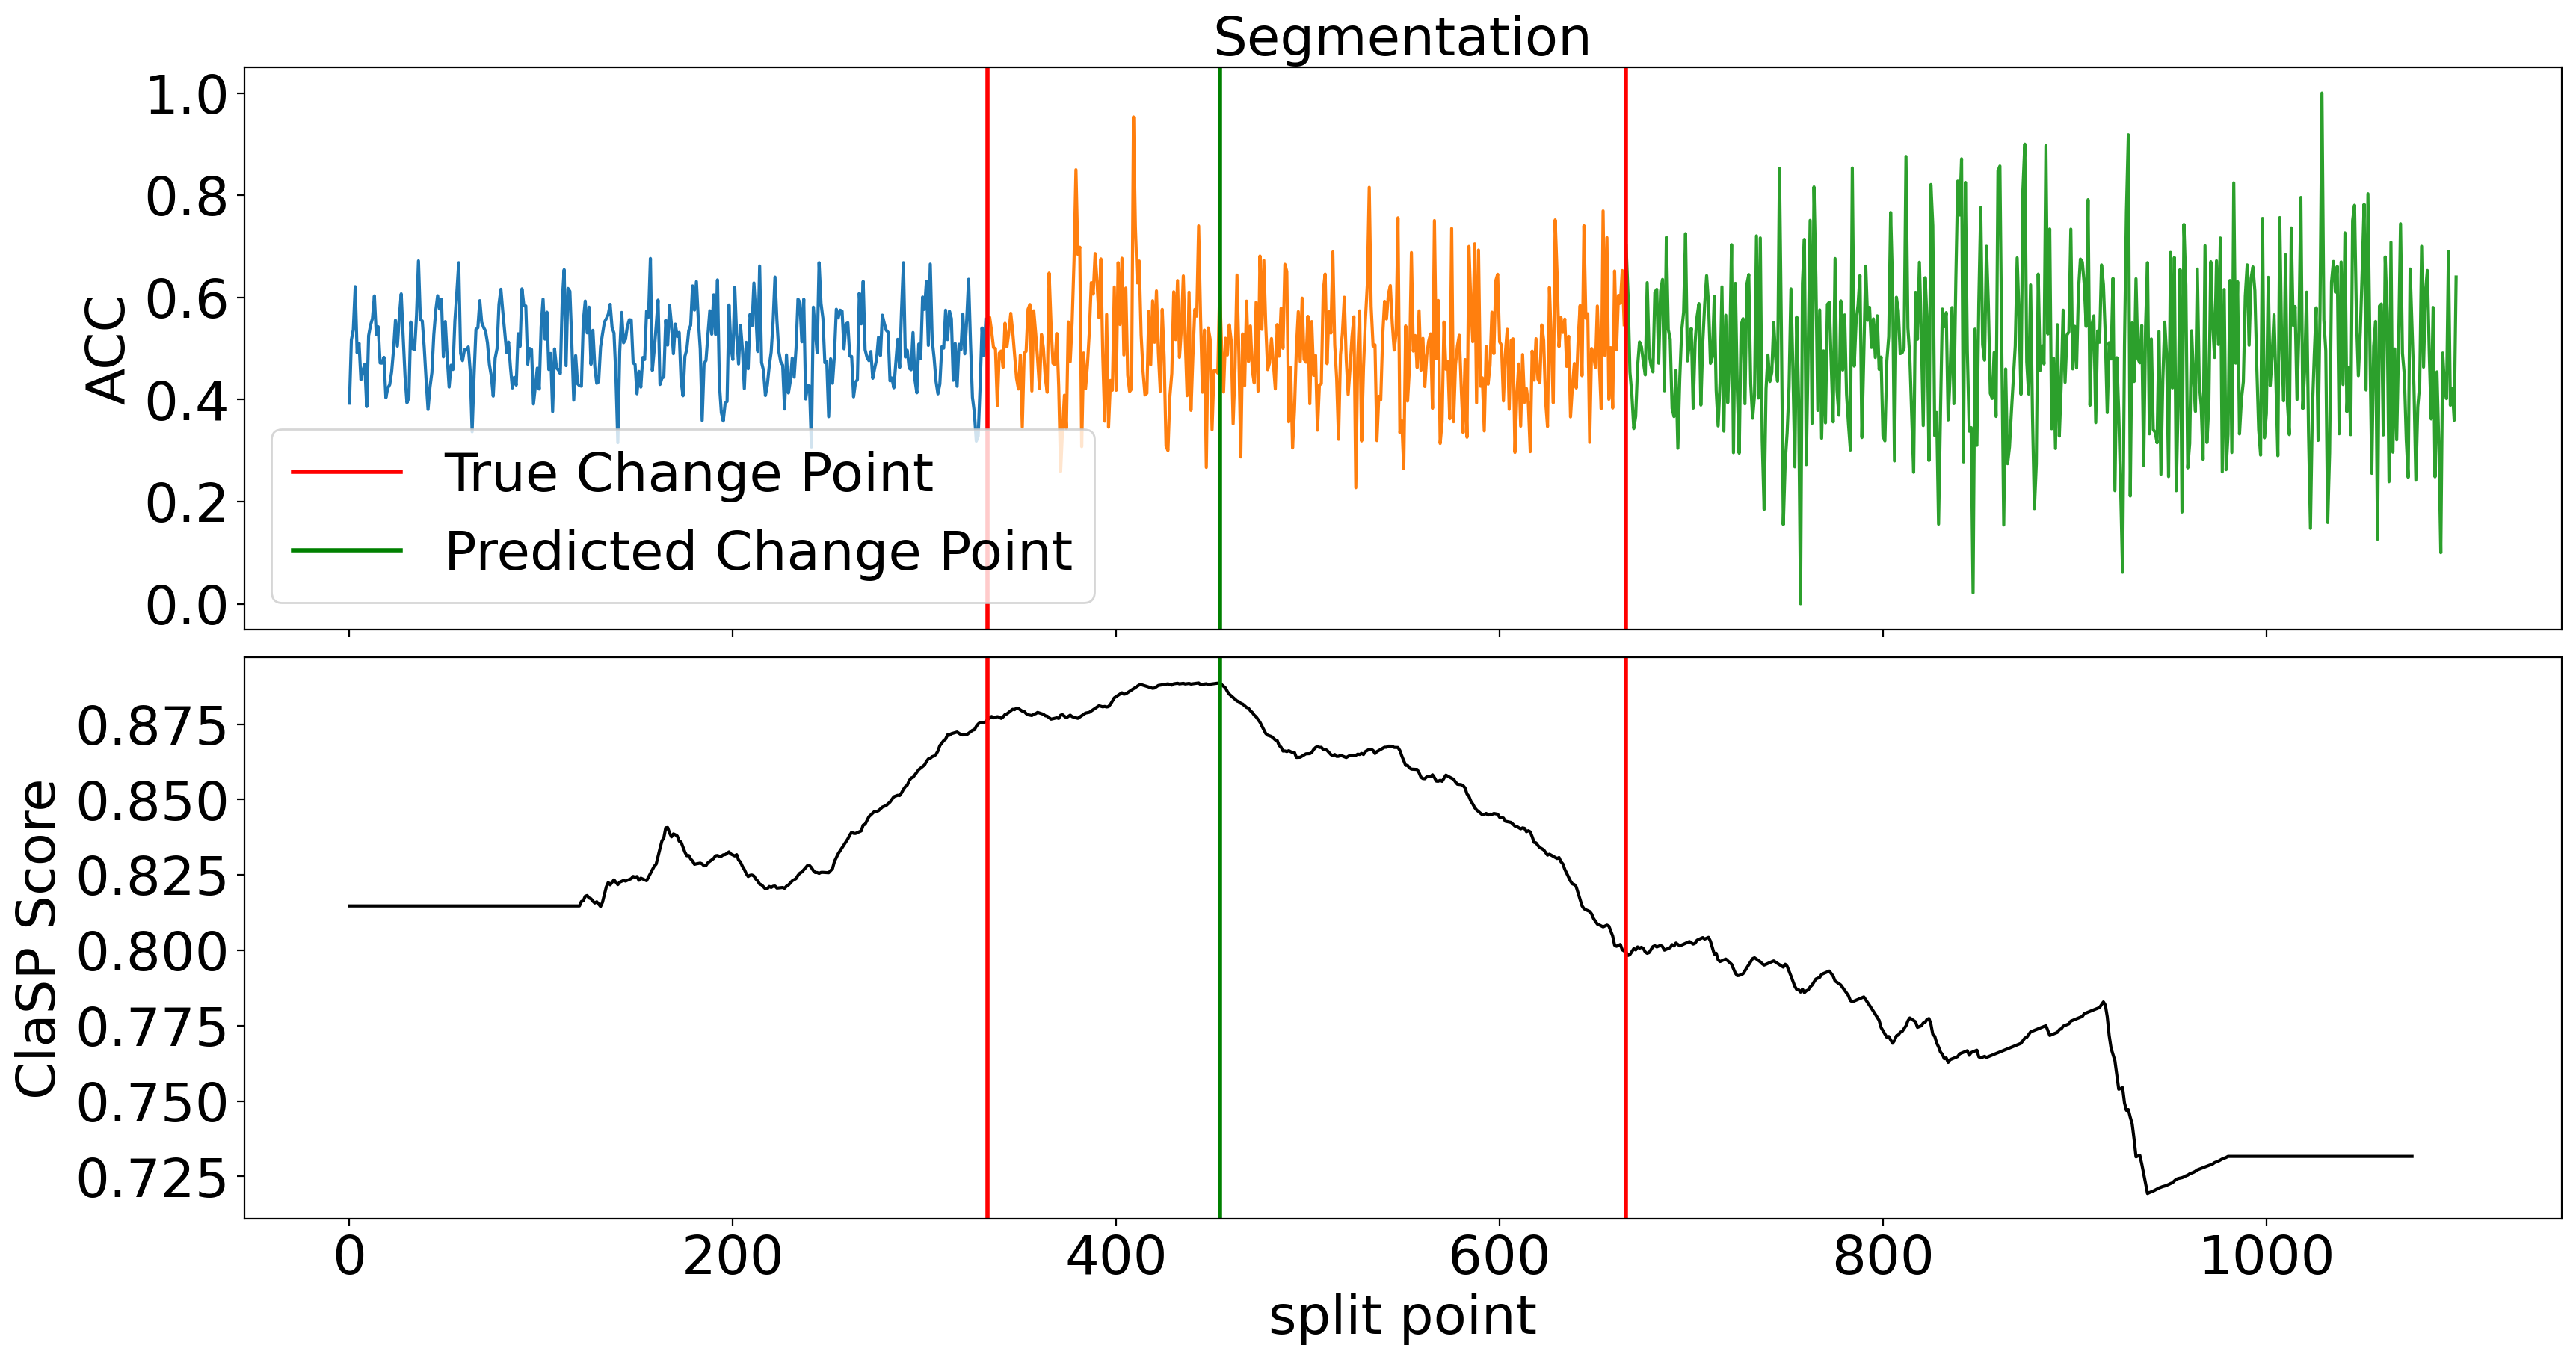

In [220]:
tcps = np.array([333, 666])
ts = data.iloc[:, 0].to_numpy()
clusters = ClaSP(ts, tcps)
# len(np.array(data.iloc[:, 0]))
print(clusters)

In [221]:
cols = data.columns
for i in range(len(cols)):
    
    print("--------------------------------")
    print(f"Stationarity test for {cols[i]}")
    print("--------------------------------")
    adf_test(data[cols[i]])

--------------------------------
Stationarity test for Z1
--------------------------------
Results of Dickey-Fuller Test:


NameError: name 'adfuller' is not defined

In [ ]:
# heatmaps = mutualinfo.stack_mi_mat(data)
for i in range(len(heatmaps)):
    
    cause = np.array(heatmaps[i])
#     cause[cause < 1] = 0
    
    vars = ['rain', 'temperature_outside', 'pressure_outside', 'gw_mb',
       'gw_sr', 'gw_sg', 'gw_west', 'gw_knee', 'gw_south', 'wind_x', 'winx_y',
       'snow_load', 'humidity', 'glob_radiaton', 'strain_ew_uncorrected',
       'strain_ns_uncorrected', 'strain_ew_corrected', 'strain_ns_corrected',
       'tides_ew', 'tides_ns']
    
    df = pd.DataFrame(cause, index=vars, columns=vars)
    plot_heatmap(df, cause)

: 

In [ ]:
cause = [[1, 0.00021124628604152207, 9.376943665984072e-13, 0.32186177293190343, 0.00021124628604152207, 0.061668972015540224, 0.061668972015540224, 0.00021124628604152207],
         [0.32186177293190343, 1, 0.00021124628604152207, 0.00021124628604152207, 0.32186177293190343, 9.376943665984072e-13, 0.00021124628604152207, 0.00021124628604152207],
         [0.9923441916812492, 0.00021124628604152207, 1, 0.9245359905186725, 0.061668972015540224, 0.6144534801742575, 0.9737515143357114, 0.9923441916812492],
         [0.061668972015540224, 0.32186177293190343, 0.00021124628604152207, 1, 0.061668972015540224, 0.061668972015540224, 9.376943665984072e-13, 0.00021124628604152207],
         [0.32186177293190343, 0.32186177293190343, 0.32186177293190343, 0.32186177293190343, 1, 0.32186177293190343, 0.9245359905186725, 0.00021124628604152207],
         [0.061668972015540224, 0.061668972015540224, 0.061668972015540224, 0.061668972015540224, 0.32186177293190343, 1, 0.061668972015540224, 9.376943665984072e-13],
         [0.00021124628604152207, 0.00021124628604152207, 9.376943665984072e-13, 0.061668972015540224, 0.061668972015540224, 0.00021124628604152207, 1, 9.376943665984072e-13],
         [0.061668972015540224, 0.6144534801742575, 0.061668972015540224, 0.32186177293190343, 0.061668972015540224, 0.6144534801742575, 0.061668972015540224, 1]]

vars = ['temperature_outside', 'pressure_outside', 'gw_west', 'gw_knee', 'gw_south', 'winx_y', 'snow_load', 'strain_ew_corrected']
df = pd.DataFrame(cause, index=vars, columns=vars)
plot_heatmap(df, cause)

: 